In [3]:
import csv
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [4]:
X = []
y = []

# Load training file.
infile = open('NumericData.csv', 'r')
s = csv.reader(infile)
next(s) # Skip header.
for row in s:
   X.append([float(x) for x in row[0:-1]])
   y.append(float(row[-1]))

np.random.seed(42)


In [5]:
numsamples = -1
n_digits = 9
data = scale(X)
n_samples, n_features = data.shape
labels = y
#n_digits = len(np.unique(labels))

sample_size = 3000

In [6]:
print("n_clusters: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


n_clusters: 9, 	 n_samples 62773, 	 n_features 15


In [7]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%9s  %.2fs   %i      %.3f    %.3f    %.3f    %.3f    %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))


In [8]:
print(79 * '_')
print('% 9s' % 'init'
    '           time    inertia homo    compl   v-meas  ARI     AMI     silhouette')

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=1),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=1),
              name="random", data=data)



_______________________________________________________________________________
init           time    inertia homo    compl   v-meas  ARI     AMI     silhouette
k-means++  1.87s   464464      0.453    0.272    0.340    0.435    0.272    0.229
   random  0.74s   571161      0.306    0.119    0.171    0.082    0.119    0.166


In [9]:
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')


PCA-based  0.83s   595698      0.300    0.122    0.173    0.078    0.121    0.133
_______________________________________________________________________________


In [10]:
###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
X[0]

[2.0, 0.0, 1.0, 0.0, 59.0, 0.0, 0.0, 21.0, 0.0, 0.0, 0.0, 78.0, 0.0, 0.0, 0.0]

In [12]:
data[0]

array([ 1.3296402 , -0.56824576, -0.24725489, -1.82610262,  0.5441272 ,
       -0.02832221, -0.41585598, -0.82608167, -0.51658633, -0.30962689,
       -0.5613789 ,  1.24645921, -0.14966841, -0.04054047, -0.09323774])

In [13]:
reduced_data[:7]

array([[-0.42006168, -1.56506145],
       [ 1.55552896, -2.14070868],
       [ 1.97889687,  0.6390229 ],
       [ 1.00084951, -0.56828781],
       [-0.89300547,  0.42122685],
       [-0.89552585,  0.44019825],
       [ 1.90913514, -1.849964  ]])

In [14]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].


In [15]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


In [16]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])


In [20]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)


In [21]:
plt.rcParams['figure.figsize'] = [15, 10]

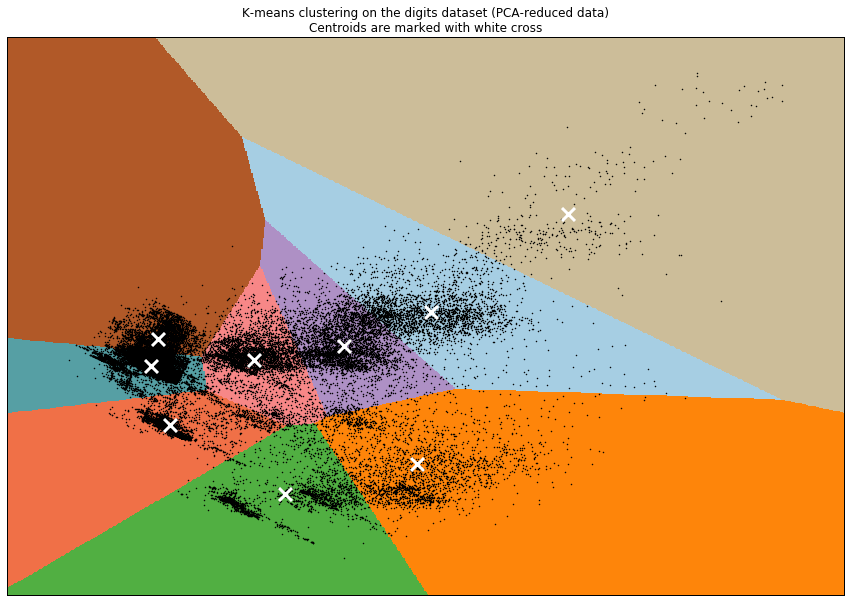

In [22]:
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()